In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import mkl
mkl.set_num_threads(1)

48

In [80]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh
from tqdm import tqdm
from matplotlib.colors import ListedColormap

# Settings

In [4]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"),
}

# plot settings for different configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# Background

In [6]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)
bckg_histo["Gen-2"] = copy(bckg_histo["IceCube"])

# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

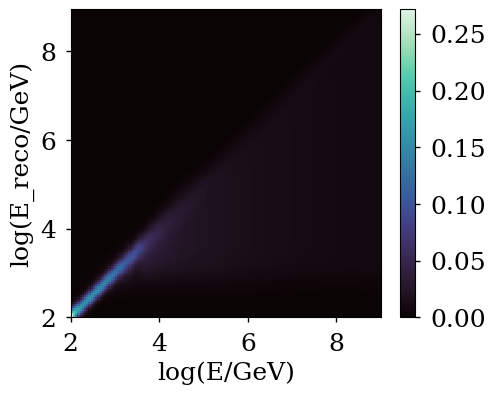

In [7]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true

improved_eres.plot()

# PSF-Energy grid from the smearing matrix

In [8]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Flux definition

In [9]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 and TXS0506 source parameters

In [10]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(BASEPATH, "local/ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11

# TXS parameters
with open(join(BASEPATH, "local/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2.
PHI_TXS = 2.7E-20
E0_TXS = txs_contour["E0"] 

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [11]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [12]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5

ngc 1068: 85.75926927315574
txs 0506+056: 4.835632528017905


# Set up LLH function

In [13]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def ps_llh_multi(
    x,
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_bckg_flux,
    all_k,
    all_eres,
    shape,
    e_0,
    phi_0,
):
    """
    Calculate the total log-likelihood across multiple datasets with different properties.

    Parameters:
        x (list): Fit parameters.
        all_aeff_factor_s (list): List of effective area factors for the signal for each dataset.
        all_aeff_factor_b (list): List of effective area factors for the background for each dataset.
        all_bckg_flux (list): List of background flux values for each dataset.
        all_k (list): List of observation/Asimov data for each dataset.
        all_eres (list): List of energy resolutions for each dataset.
        shape (str): Flux shape.
        e_0 (float): Normalization energy.
        phi_0 (float): Normalization flux.

    Returns:
        float: Total log-likelihood value across all datasets.

    Note:
        This function assumes that there are multiple datasets with different properties.
    """
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += ps_llh_single(
            x=x,
            aeff_factor_s=aeffs,
            aeff_factor_b=all_aeff_factor_b[i],
            bckg_flux=all_bckg_flux[i],
            k_i=all_k[i],
            energy_resolution=all_eres[i],
            e_0=e_0,
            phi_0=phi_0,
            shape=shape,
        )
    return llh
def setup_multi_llh(eres, conf, bg_config, sig_config, src_flux=ngc_flux, verbose=False, return_s_b=False):
    """
    Set up the components required for calculating the log-likelihood across multiple datasets.

    Parameters:
        eres (dict or array): Dictionary of arrays/mephistograms or single array/mephistogram representing the
                                  energy resolutions for each dataset. If a dictionary is provided,
                                  it should map dataset identifiers to their corresponding energy resolution.
                                  If a float is provided, the same energy resolution will be used for all datasets.
        conf (tuple): Tuple containing two lists - the first list represents dataset identifiers,
                      and the second list contains corresponding scaling factors corresponding to
                      either a lifetime scaling or effective-area scaling.
        verbose (bool, optional): Whether to print additional information. Default is False.
        return_s_b (bool, optional): Whether to return the individual signal and background histograms. Default is False.

    Returns:
        tuple: A tuple containing the following components for each dataset:
            - all_aeff_factor_s (list): List of effective area factors for the signal.
            - all_aeff_factor_b (list): List of effective area factors for the background.
            - all_k (list): List of observation/Asimov data.
            - all_bckg_flux (list): List of background flux values.
            - if return_s_b: all_k_s, all_k_b (lists): List of signal and background histograms

    Note:
        This function assumes that the configuration parameters and required functions (e.g., `calc_aeff_factor`,
        `atmo_background`, `astro_flux`, `array_source_interp`) are defined and accessible in the global namespace.
        If `eres` is a dictionary, each dataset identifier should have an associated energy resolution value.
        If `eres` is an  array/mephistogram, the same energy resolution will be used for all datasets.
    """

    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k = []
    all_bckg_flux = []
    all_eres = []
    if return_s_b:
        all_k_s = []
        all_k_b = []

    for ident, factor in zip(*conf):
        # Calculate effective area factors for background and signal
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **bg_config) * factor
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **sig_config) * factor

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], bckg_histo[ident], sindec_mids, axis=1
        )
        # Determine the energy resolution for the current dataset
        current_eres = eres[ident] if isinstance(eres, dict) else eres

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal with power law spectrum
        k_s = astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=emids,
            energy_resolution=current_eres,
            phi_scaling=1,
            flux_shape=src_flux,  # powerlaw
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k.append(k_s + k_b)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(current_eres)
        if return_s_b:
            all_k_s.append(k_s)
            all_k_b.append(k_b)
    if return_s_b:
        return (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        )
    else:
        return all_aeff_factor_s, all_aeff_factor_b, all_k, all_bckg_flux, all_eres

# Nominal PS fit

In [14]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        baseline_eres,
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.07304711]
Signal fit parameters: [1.  1.  3.2]
TS check: -320367.49123285373 (fit:  -320367.49123285373 )
-2 Delta LLH: 20.549352762289345
P-VALUE: 3.4495682691144156e-05 SIGNIFICANCE: 3.9797376381174936

Plenum-1
Atmo-only normalization: [1.09856876]
Signal fit parameters: [1.  1.  3.2]
TS check: -1422714.3292222458 (fit:  -1422714.3292222458 )
-2 Delta LLH: 113.59170089685358
P-VALUE: 2.1571262076425004e-25 SIGNIFICANCE: 10.347084175125685

Plenum-2
Atmo-only normalization: [1.08138116]
Signal fit parameters: [1.  1.  3.2]
TS check: -1380717.5057425192 (fit:  -1380717.5057425192 )
-2 Delta LLH: 248.65746376337484
P-VALUE: 1.0109223581336806e-54 SIGNIFICANCE: 15.534646366048047



# Scan energy threshold
## Standard PS and energy spectrum

Idea:
Rise the energy threshold for one or more detectors and see how point-source studies perform

In [15]:
from copy import deepcopy

### config

In [70]:
ethresh_detector_configurations = {
    "IceCube": (["IceCube"], [1], ["s"]),
    "2 x IceCube": (["IceCube"], [2], ["s"]),
    "IceCube-Gen2": (["IceCube"], [GEN2_FACTOR], ["s"]),
    "P-ONE": (["IceCube", "P-ONE"], [1, 1], ["n", "s"]),
    "Plenum-1": (
        ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [2, 1, 1, 1],
        ["n", "s", "s", "s"],
    ),
    "wild": (
        ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [10, 11, 5, 8],
        ["n", "s", "s", "s"],
    ),
    "Plenum-2": (
        ["IceCube", "Gen-2", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [2, 1, 1, 1, 1],
        ["n", "s", "s", "s", "s"],
    ),
    "Plenum-2-scaleAll": (
        ["IceCube", "Gen-2", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [2, 1, 1, 1, 1],
        ["s", "s", "s", "s", "s"],
    ),
}
# "s" indicates scaling of energy threshold, "n" means no scaling

### analysis

In [67]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source
verbose = False
optimize = True
results = []
sources = ["ngc", "txs"]
enums = (
    len(logE_reco_mids[logE_reco_mids <= 5]) + 1
)  # some range where the energy threshold is scaled
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"] #
stepper = 2
for i, key, source in product(range(0, enums, stepper), detector_keys, sources):
    conf = ethresh_detector_configurations[key]

    if source == "ngc":
        current_src_config = copy(ngc_src_config)
        current_src_config["dec"] = 0
        current_bg_config = copy(ngc_bg_config)
        current_bg_config["dec"] = 0
        src_flux = ngc_flux
    elif source == "txs":
        current_src_config = copy(txs_src_config)
        current_src_config["dec"] = 0
        current_bg_config = copy(txs_bg_config)
        current_bg_config["dec"] = 0
        src_flux = txs_flux

    # energy smearing
    energy_resolution_thresh = deepcopy(baseline_eres)
    # set reco below threshold to zero
    energy_resolution_thresh.histo[:, :i] = 0
    e_res_multi = {
        dk: energy_resolution_thresh if sc == "s" else baseline_eres
        for sc, dk in zip(conf[2], conf[0])
    }

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        eres=e_res_multi,
        conf=conf[:2],
        bg_config=current_bg_config,
        sig_config=current_src_config,
        src_flux=src_flux,
        return_s_b=True,
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=src_flux.E0,
        phi_0=src_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    if optimize:
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, src_flux.gamma),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    else:
        pval = chi2.sf(out_bckg[1] - global_llh((1, 1, src_flux.gamma)), 2)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": logE_reco_mids[i],
            "Configuration": key,
            "Source": source,
            "PL index": rf"$\gamma$ = {src_flux.gamma}",
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(all_k_s),
            "n_b": np.sum(all_k_b),
        }
    )
    if optimize:
        results[-1].update({
            "signal_Nbg": out_comp[0][0],
            "signal_Ns": out_comp[0][1],
            "signal_gamma": out_comp[0][2],
            "TS": out_bckg[1] - out_comp[1],
            "TS_check": out_bckg[1] - global_llh((1, 1, src_flux.gamma)),
        })

    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(all_k_b))
        print("Signal:", np.sum(all_k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, src_flux.gamma)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        break

results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))

### plotting

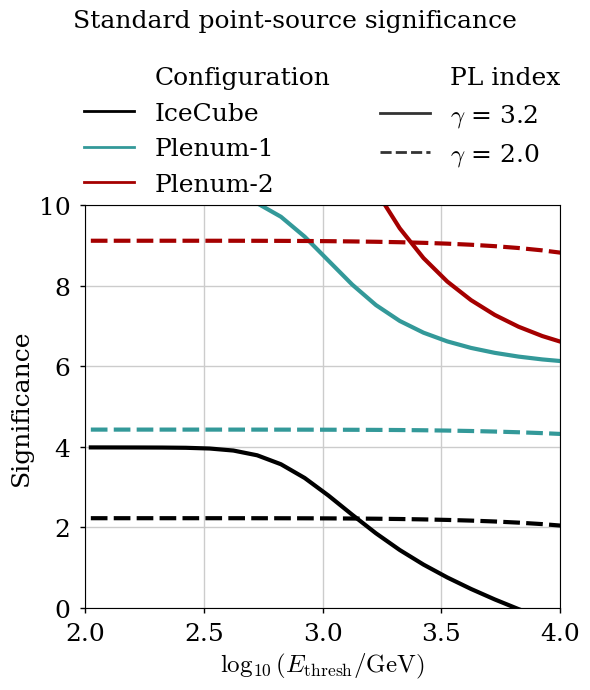

In [118]:
results = pd.read_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 7))

ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Configuration",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in detector_keys],
    lw=3,
)
ax.set_ylim(0, 10)
ax.set_xlim(2, 4)
f.suptitle("Standard point-source significance", fontsize=18)
leg = ax.legend(
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, 1.4),
    #columnspacing=0.8,
    frameon=False,
)
f.tight_layout()
f.subplots_adjust(hspace=0.15, top=0.7)
f.savefig("../../plots/ngc_paper/energy_threshold_significance_scan.pdf")

# NGC spectral shape + energy threshold

In [19]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
ident = "IceCube"
Gamma_cut = 2.0
logE_cut = 3.5 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) 
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 1.4516980030327629
flux normalization before 5e-14 after 7.258490015163814e-14


##  baseline spectral fit

In [20]:

verbose = False
results = []
idents = ["IceCube", "Plenum-1", "Plenum-2"]
source = "ngc"

for ident in idents:
    conf = detector_configurations[ident]
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # select one resolution for all data sets
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        return_s_b=True,
        src_flux= ngc_cut_flux
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
    )
    pl_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_llh,
        x0=(1.2, 1.2, 3.0),
        bounds=([1E-2, 10], [1E-2, 10], [1, 6]),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            "ident": ident,
            "Detector": det_plotting[ident]["plainlabel"],
            "Source": source,
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(all_k_s),
            "n_b": np.sum(all_k_b),
            "Energy Reco": "50% improved",
        }
    )

    if False:
        print("Asimov data sum:")
        print("Background:", np.sum(all_k_b))
        print("Signal:", np.sum(all_k_s))
        print("Signal fit parameters:", out_comp[0])
        print("Powerlaw fits (n_bg, n_s, gamma):", out_bckg[0])
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
    check = global_llh((1, 1, Gamma_cut, logE_cut))
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")

results = pd.DataFrame(results)

bckg params: [0.9981821 0.6738116 3.0665597]
P-VALUE: 0.040727567654161335 SIGNIFICANCE: 1.74230473515884
pval check: 0.03997232304540424 ratio: 0.9814561818380546

bckg params: [0.9970425  0.64962424 3.0143274 ]
P-VALUE: 7.608500851973544e-06 SIGNIFICANCE: 4.3255235393782705
pval check: 7.0201311982486014e-06 ratio: 0.9226694370978052

bckg params: [0.99796047 0.66183069 3.04436119]
P-VALUE: 5.211825841952675e-12 SIGNIFICANCE: 6.800527850794852
pval check: 4.337267518716988e-12 ratio: 0.8321973239788797



## energy threshold scan

In [62]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source
verbose = False
optimize = False
results = []
enums = len(logE_reco_mids[logE_reco_mids <= 4]) + 1

### using improved energy resolution ###
detector_keys = ["Plenum-2", "IceCube-Gen2"] # ["IceCube", "Plenum-1", "Plenum-2"]
stepper = 2
for i, key in product(range(0, enums, stepper), detector_keys):
    conf = ethresh_detector_configurations[key]

    current_src_config = deepcopy(ngc_src_config)
    current_src_config["dec"] = 0
    current_bg_config = deepcopy(ngc_bg_config)
    current_bg_config["dec"] = 0

    # energy smearing
    energy_resolution_thresh = deepcopy(improved_eres)
    # set reco below threshold to zero
    energy_resolution_thresh.histo[:, :i] = 0
    e_res_multi = {
        dk: energy_resolution_thresh if sc == "s" else improved_eres
        for sc, dk in zip(conf[2], conf[0])
    }

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        eres=e_res_multi,
        conf=conf[:2],
        bg_config=current_bg_config,
        sig_config=current_src_config,
        src_flux=ngc_cut_flux,
        return_s_b=True,
    )
    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2, 1.2, 3.0),
        bounds=([1E-2, 10], [1E-2, 10], [1, 6]),
        approx_grad=True,
    )
    bg_ts = out_bckg[1]

    # this fit is not really needed, but good for crosschecking the code
    if optimize:
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut),
            approx_grad=True,
        )
        pval = chi2.sf(bg_ts - out_comp[1], 1)
    else:
        pval = chi2.sf(bg_ts - global_llh((1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut)), 1)
    significance = norm.isf(pval)

    if optimize:
        for out in [out_bckg, out_comp]:
            if out[2]["warnflag"] == 2:
                print("WARNING, bg failed")
                print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": logE_reco_mids[i],
            "Configuration": key,
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(all_k_s),
            "n_b": np.sum(all_k_b),
            "bg_Nbg": out_bckg[0][0],
            "bg_Ns": out_bckg[0][1],
            "bg_gamma": out_bckg[0][2],
        }
    )
    if optimize:
        results[-1].update({
            "signal_Nbg": out_comp[0][0],
            "signal_Ns": out_comp[0][1],
            "signal_gamma": out_comp[0][2],
            "TS": out_bckg[1] - out_comp[1],
            "TS_check": out_bckg[1] - global_llh((1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut)),
        })


    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(all_k_b))
        print("Signal:", np.sum(all_k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        break
    if False:
        plt.figure()
        title = f"s: {significance:1.2f}, et:{logE_reco_mids[i]:1.2f}, idx:{i}, bg: "
        for ib in out_bckg[0]:
            title += f"{ib:1.2f}, "
        plt.title(title)
        for ii, ks in enumerate(all_k_s):
            p = plt.plot(ks.sum(axis=0), label= conf[0][ii])
            plt.plot(all_k[ii].sum(axis=0), ls="--", color=p[0].get_color())
            plt.plot(all_k_b[ii].sum(axis=0), ls=":", color=p[0].get_color())
        plt.yscale("log")
        plt.ylim(1E-3, 1E4)
        plt.legend()
        plt.show()
results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))

## this looks weird
probably going to leave that out

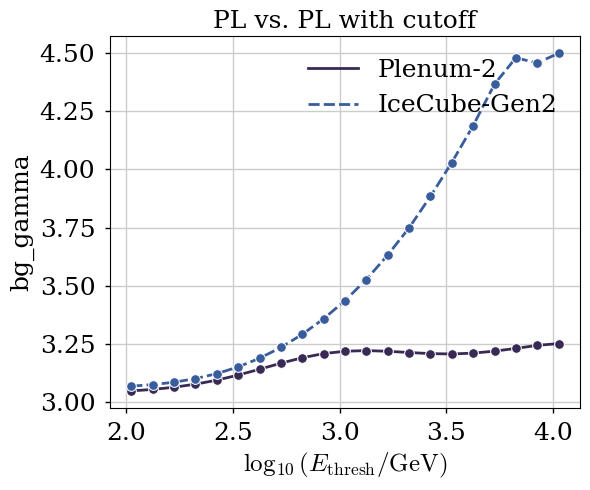

In [63]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="bg_gamma",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()

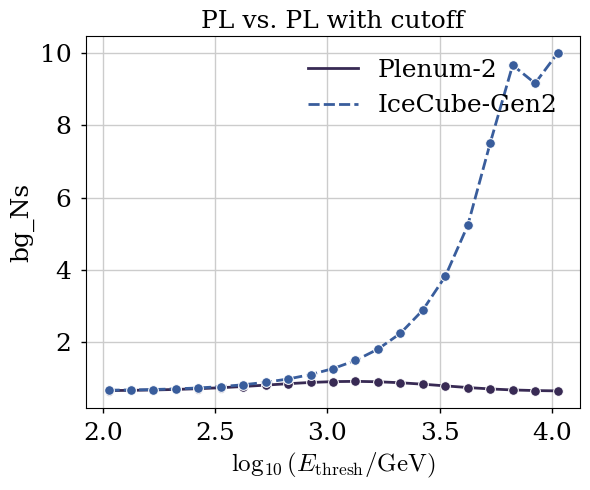

In [64]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="bg_Ns",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()

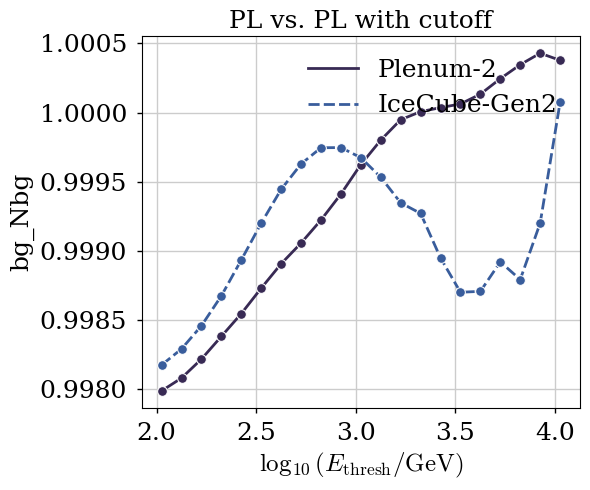

In [65]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="bg_Nbg",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()

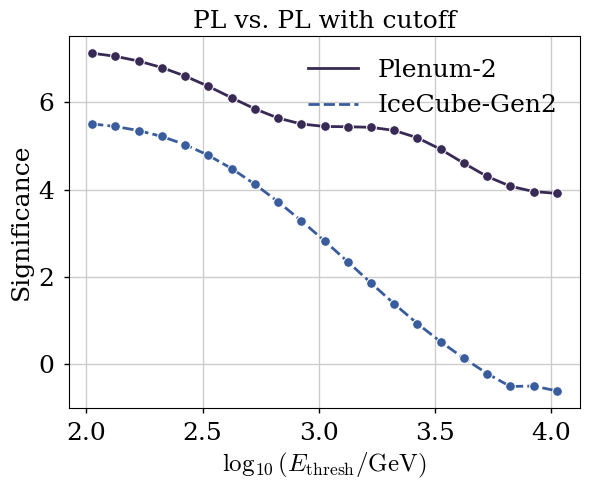

In [66]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()
f.savefig("../../plots/ngc_paper/energy_threshold_significance_spectral_scan.pdf")

## combined plot

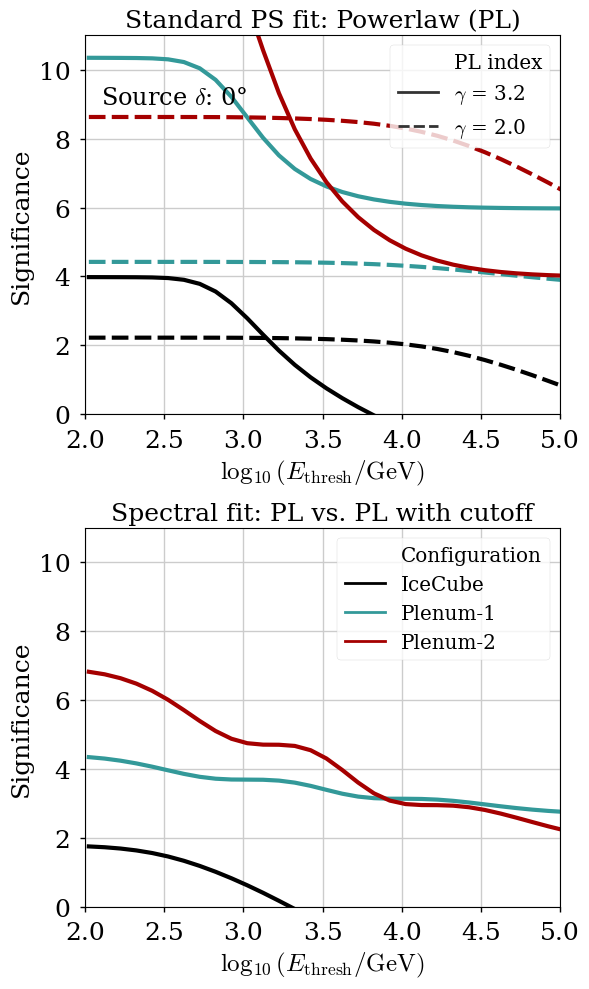

In [25]:
results = pd.read_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))
f, axes = plt.subplots(nrows=2, figsize=(6, 10))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Configuration",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in idents],
    #palette="magma",
    #palette=np.array(sns.color_palette("magma", n_colors=10))[[0, 5, 7]],
    ax=axes[0],
    lw=3,
)
ax.text(s=r"Source $\delta$: 0°", x=2.1, y=9, fontsize="xx-large")
ax.set_ylim(0, 11)
ax.set_xlim(2, 5)
ax.set_title("Standard PS fit: Powerlaw (PL)")
h, l = ax.axes.get_legend_handles_labels()
ax.axes.legend_.remove()
ax.legend(h[-3:], l[-3:], frameon=True, loc=1, fontsize="x-large")


results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Configuration",
    palette=[det_plotting[ident]["color"] for ident in idents],
    #palette="magma",
    #palette=np.array(sns.color_palette("magma", n_colors=10))[[0, 5, 7]],
    lw=3,
    ax=axes[1],
)
ax.set_ylim(0, 11)
ax.set_xlim(2, 5)
ax.set_title("Spectral fit: PL vs. PL with cutoff")
ax.axes.legend_.remove()
ax.legend(
    h[:-3], l[:-3], loc=1, frameon=True, fontsize="x-large"
)  # , bbox_to_anchor=(1, 0.5), frameon=False)

f.tight_layout()
f.savefig("../../plots/ngc_paper/energy_threshold_significance_spectral+PS_scan.pdf")


In [23]:
print("Ü")

Ü


# NGC cutoff parameter checks

In [72]:
# cutoff parameters
Gamma_cuts = np.round(np.arange(1.6, 2.5, step=0.1), 2)
logE_cuts = np.round(np.arange(3, 4.1, step=0.1), 2)  # log10 (Ecut / GeV)
identifier = "IceCube"  # "Plenum-1"
es_ident = "improved"
pvals_ngc = []

for Gamma_cut, logE_cut in product(Gamma_cuts, logE_cuts):
    # define a temporary baseline flux for first fit iteration
    tmp_flux = PLcut_flux(PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff")

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **ngc_src_config)

    ### scale the fluxes such that the event numbers match as first iteration
    astro_ev_sum_pl = np.sum(
        astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=emids,
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=ngc_flux,
        )
    )

    # cutoff
    astro_ev_sum_cut = np.sum(
        astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=emids,
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=tmp_flux,
        )
    )
    flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut

    # define the newly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
    )

    ## add IceCube to the other detector configs
    if identifier != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    # asimov data
    bckg_flux = array_source_interp(
        ngc_src_config["dec"], bckg_histo[identifier], sindec_mids, axis=1
    )
    k_b = atmo_background(
        aeff_factor_bckg,
        bckg_vals=bckg_flux,
        energy_resolution=improved_eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        improved_eres,
        1,
        ngc_cut_flux_tmp,  # powerlaw with cutoff
    )

    k_i = k_s + k_b

    dct = dict(
        aeff_factor_s=aeff_factor_signal,
        aeff_factor_b=aeff_factor_bckg,
        k_i=k_i,
        e_0=ngc_cut_flux_tmp.E0,
        energy_resolution=improved_eres,
        bckg_flux=bckg_flux,
    )
    pl_func = lambda x: ps_llh_single(
        x,
        shape="powerlaw",
        phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.0, 1.0, 3.0),
        approx_grad=True,
    )

    global_llh = lambda x: ps_llh_single(
        x,
        shape="powerlaw with cutoff",
        phi_0=ngc_cut_flux_tmp.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, Gamma_cut, logE_cut),
        approx_grad=True,
    )

    # check the LLH at the "correct" parameter position
    check = global_llh((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    pvals_ngc.append(
        {
            "identifier": identifier,
            "e_smearing": es_ident,
            "pval": pval,
            "pval_check": pval_check,
            "significance": norm.isf(pval),
            "significance_check": norm.isf(pval_check),
            "gamma_cut": Gamma_cut,
            "logE_cut": logE_cut,
            "flux_scaling": flux_scaling_cut,
            "flux_cut_norm": PHI_NGC * flux_scaling_cut,
            "out_pl_gamma": out_bckg[0][2],
            "out_pl_norm": out_bckg[0][1],
            "out_plc_cut": out_comp[0][3],
            "out_plc_gamma": out_comp[0][2],
            "out_plc_norm": out_comp[0][1],
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pd.to_pickle(
    pvals_ngc, join(BASEPATH, f"local/energy_cut_wiggle_{es_ident}_{identifier}.pckl")
)

In [73]:
#identifier = "Plenum-1"
pvals_ngc = pd.read_pickle(join(BASEPATH, f"local/energy_cut_wiggle_improved_{identifier}.pckl"))
pvals_ngc["gamma_pl_diff"] = pvals_ngc.out_pl_gamma - GAMMA_NGC
pvals_ngc["norm_pl_diff"] = pvals_ngc.out_pl_norm - 1
pvals_ngc["pcheck_ratio"] = pvals_ngc.pval / pvals_ngc.pval_check

pivot_sigma = pvals_ngc.pivot("logE_cut", "gamma_cut", "significance")
pivot_gamma_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "gamma_pl_diff")
pivot_norm_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "norm_pl_diff")

## plotting

In [74]:
gamma_err = 0.2
norm_err = 0.2

In [75]:
sel = pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

print(sel.to_latex(float_format="%.2f"))

sel = sel[sel.columns[np.abs(sel.columns - 2) <= 0.21]]
sel = sel.loc[
    sel.index <= 3.7
]

print(sel.to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrrrrr}
\toprule
gamma\_cut &  1.6 &  1.7 &  1.8 &  1.9 &  2.0 &  2.1 &  2.2 &  2.3 &  2.4 \\
logE\_cut &      &      &      &      &      &      &      &      &      \\
\midrule
3.0      & 1.92 & 1.83 & 1.74 & 1.65 & 1.56 &  NaN &  NaN &  NaN &  NaN \\
3.1      & 1.98 & 1.89 & 1.79 & 1.70 & 1.60 & 1.50 & 1.40 &  NaN &  NaN \\
3.2      & 2.04 & 1.95 & 1.85 & 1.75 & 1.64 & 1.54 & 1.43 & 1.32 & 1.20 \\
3.3      & 2.10 & 2.00 & 1.90 & 1.80 & 1.69 & 1.58 & 1.46 & 1.34 & 1.22 \\
3.4      & 2.14 & 2.04 & 1.94 & 1.84 & 1.73 & 1.61 & 1.49 & 1.37 & 1.24 \\
3.5      &  NaN & 2.07 & 1.97 & 1.86 & 1.75 & 1.63 & 1.51 & 1.39 & 1.26 \\
3.6      &  NaN &  NaN &  NaN & 1.87 & 1.76 & 1.64 & 1.52 & 1.39 & 1.26 \\
3.7      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 1.52 & 1.39 & 1.25 \\
3.8      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 1.37 & 1.23 \\
3.9      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 1.20 \\
4.0      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN 

In [76]:
# select roughly matching results
pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

# --> for gamma=2, ecut=3.5 yields the best separation,
# while still compatible within the IC error contour
# ecut=3.6 would also be OK, but the significance is not much larger than for 3.5
# but it is much less compatible with the IC results


gamma_cut,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4
logE_cut,,,,,,,,,
3.0,1.916879,1.830678,1.742113,1.651253,1.558189,NaN,NaN,NaN,NaN
3.1,1.979578,1.888588,1.794875,1.698551,1.599766,1.498685,1.395504,NaN,NaN
3.2,2.042979,1.948375,1.850336,1.749049,1.644727,1.537619,1.428004,1.316200,1.202549
3.3,2.098415,2.002652,1.901989,1.797408,1.688897,1.576775,1.461415,1.343231,1.222695
3.4,2.138023,2.042860,1.942448,1.837051,1.726141,1.610825,1.491261,1.367952,1.241478
3.5,NaN,2.067449,1.966912,1.861822,1.751016,1.634870,1.512639,1.385939,1.255038
3.6,NaN,NaN,NaN,1.872944,1.760273,1.644323,1.521939,1.393475,1.259824
3.7,NaN,NaN,NaN,NaN,NaN,NaN,1.517281,1.388364,1.253468
3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.370034,1.234848


In [77]:
pivot_gamma_diff[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

gamma_cut,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4
logE_cut,,,,,,,,,
3.0,0.069176,0.093994,0.120200,0.147971,0.177330,NaN,NaN,NaN,NaN
3.1,-0.000509,0.023806,0.049118,0.076543,0.105369,0.136202,0.168917,NaN,NaN
3.2,-0.064512,-0.040763,-0.015932,0.010440,0.038758,0.069250,0.101557,0.136061,0.172684
3.3,-0.125900,-0.104640,-0.076367,-0.050342,-0.022273,0.007475,0.039469,0.073808,0.110282
3.4,-0.175742,-0.156055,-0.134006,-0.110621,-0.079642,-0.049827,-0.017929,0.016014,0.052838
3.5,NaN,-0.199925,-0.180962,-0.158861,-0.133963,-0.107375,-0.071915,-0.037586,-0.000973
3.6,NaN,NaN,NaN,-0.199917,-0.184162,-0.152822,-0.124483,-0.088125,-0.051074
3.7,NaN,NaN,NaN,NaN,NaN,NaN,-0.166560,-0.136066,-0.097961
3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.180752,-0.142296


## with colored significance

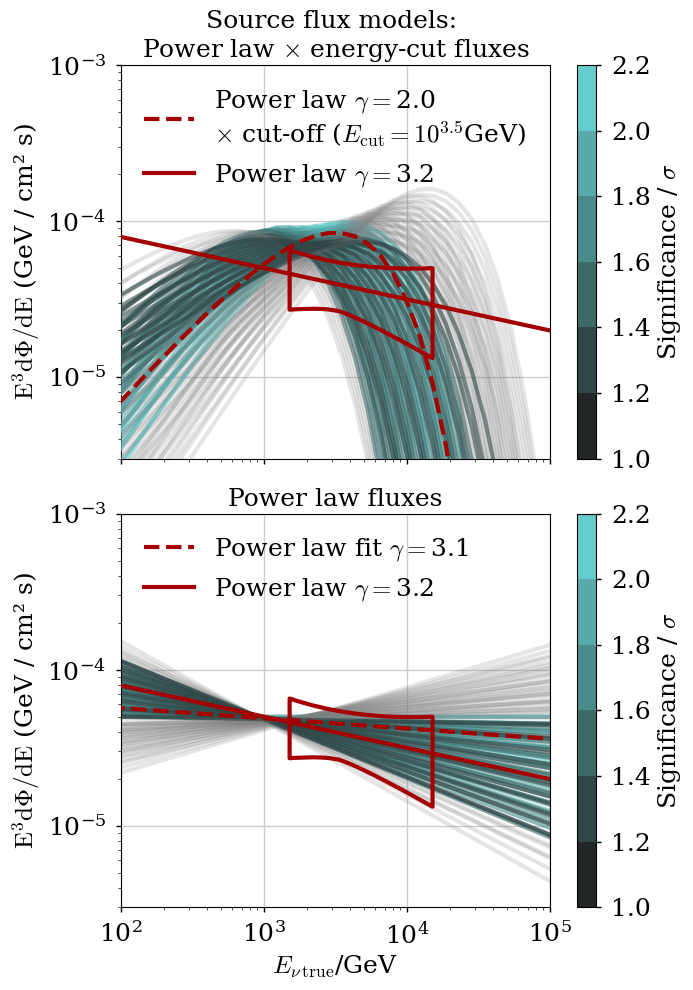

In [91]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy-cut fluxes")
ax[1].set_title("Power law fluxes")

cur_cmap = ListedColormap(
    sns.dark_palette(det_plotting["P-ONE"]["color"], reverse=False, n_colors=6)
)

sigma_min = 1  # np.min(pvals_ngc.significance)
sigma_max = 2.2  # np.max(pvals_ngc.significance)
color_projection = lambda x: cur_cmap((x - sigma_min) / (sigma_max - sigma_min))
sm = plt.cm.ScalarMappable(
    cmap=cur_cmap, norm=plt.Normalize(vmin=sigma_min, vmax=sigma_max)
)

for (Gamma_cut, logE_cut), series in pvals_ngc.groupby(["gamma_cut", "logE_cut"]):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[Gamma_cut].loc[logE_cut]:
        alpha_val = 0.6
        col = color_projection(series.iloc[0]["significance"])
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        PHI_NGC * series.iloc[0]["flux_scaling"],
        Gamma_cut,
        logE_cut,
        E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    + "\n"
    + rf"$\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == ngc_cut_flux.gamma)
    & (pvals_ngc.logE_cut == ngc_cut_flux.e_cut)
]
tmp_ngc_flux = PL_flux(
    PHI_NGC * selection.iloc[0]["out_pl_norm"],
    selection.iloc[0]["out_pl_gamma"],
    E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${tmp_ngc_flux.gamma:1.1f}",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=det_plotting["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color=det_plotting["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 1e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    cb = plt.colorbar(sm, ax=axx)
    cb.set_label(r"Significance / $\sigma$")
    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"$E_{\nu \, \rm true}$/GeV")

f.tight_layout()
f.savefig(f"../../plots/ngc_paper/pl-cut_flux_model_matching_E{y_scaling}.pdf")

## with uni significance

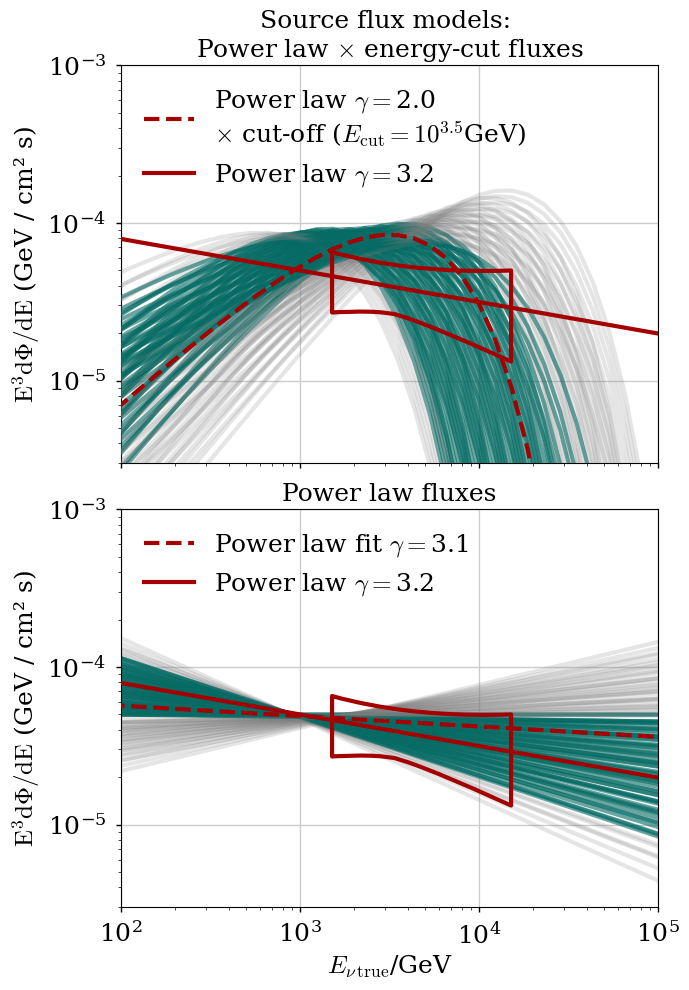

In [87]:

sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy-cut fluxes")
ax[1].set_title("Power law fluxes")

cur_color = colors[2]# det_plotting["Baikal-GVD"]["color"]

for (Gamma_cut, logE_cut), series in pvals_ngc.groupby(["gamma_cut", "logE_cut"]):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[Gamma_cut].loc[logE_cut]:
        alpha_val = 0.6
        col = cur_color
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        PHI_NGC * series.iloc[0]["flux_scaling"],
        Gamma_cut,
        logE_cut,
        E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    + "\n"
    + rf"$\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == ngc_cut_flux.gamma)
    & (pvals_ngc.logE_cut == ngc_cut_flux.e_cut)
]
tmp_ngc_flux = PL_flux(
    PHI_NGC * selection.iloc[0]["out_pl_norm"],
    selection.iloc[0]["out_pl_gamma"],
    E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${tmp_ngc_flux.gamma:1.1f}",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=det_plotting["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color=det_plotting["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 1e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"$E_{\nu \, \rm true}$/GeV")

f.tight_layout()
f.savefig(f"../../plots/ngc_paper/pl-cut_flux_model_matching_E{y_scaling}_noCM.pdf")
